In [26]:
# Note  book to explore and visualize the results tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


## load results from 2002 to 2022 season
df = pd.read_csv('..//data//results_table_2002_2022_new.csv')

df_orig = df.copy()





In [27]:
# Initialize dictionaries to hold the counts
overall_record = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Ties': 0, 'OT': 0})
home_record = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Ties': 0, 'OT': 0})
away_record = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Ties': 0, 'OT': 0})

# Iterate through each row to populate the counts
for idx, row in filtered_data_no_exhibition.iterrows():
    home_team, home_score = row['Home_Team'], row['Home_Score']
    away_team, away_score = row['Away_Team'], row['Away_Score']
    is_ot = row['OT']

    # Update Overall Records
    if home_score > away_score:
        overall_record[home_team]['Wins'] += 1
        overall_record[away_team]['Losses'] += 1
    elif home_score < away_score:
        overall_record[home_team]['Losses'] += 1
        overall_record[away_team]['Wins'] += 1
    else:
        overall_record[home_team]['Ties'] += 1
        overall_record[away_team]['Ties'] += 1

    # Update Home Records
    if home_score > away_score:
        home_record[home_team]['Wins'] += 1
        away_record[away_team]['Losses'] += 1
    elif home_score < away_score:
        home_record[home_team]['Losses'] += 1
        away_record[away_team]['Wins'] += 1
    else:
        home_record[home_team]['Ties'] += 1
        away_record[away_team]['Ties'] += 1

    # Update OT Counts
    if pd.notna(is_ot):
        overall_record[home_team]['OT'] += 1
        overall_record[away_team]['OT'] += 1
        home_record[home_team]['OT'] += 1
        away_record[away_team]['OT'] += 1

# Convert dictionaries to DataFrames
overall_df = pd.DataFrame.from_dict(overall_record, orient='index').reset_index().rename(columns={'index': 'Team'}).add_prefix('Overall_')
home_df = pd.DataFrame.from_dict(home_record, orient='index').reset_index().rename(columns={'index': 'Team'}).add_prefix('Home_')
away_df = pd.DataFrame.from_dict(away_record, orient='index').reset_index().rename(columns={'index': 'Team'}).add_prefix('Away_')

# Add 'Total_Games' and 'Win_Percent' to each DataFrame
for df, prefix in [(overall_df, 'Overall'), (home_df, 'Home'), (away_df, 'Away')]:
    df[f'{prefix}_Total_Games'] = df[[f'{prefix}_Wins', f'{prefix}_Losses', f'{prefix}_Ties']].sum(axis=1)
    df[f'{prefix}_Win_Percent'] = (df[f'{prefix}_Wins'] / df[f'{prefix}_Total_Games']) * 100

# Rename the 'Team' columns for merging
overall_df.rename(columns={'Overall_Team': 'Team'}, inplace=True)
home_df.rename(columns={'Home_Team': 'Team'}, inplace=True)
away_df.rename(columns={'Away_Team': 'Team'}, inplace=True)

# Merge DataFrames for a comprehensive view
final_df = overall_df.merge(home_df, on='Team').merge(away_df, on='Team')

# Sort by overall winning percentage
final_df_sorted = final_df.sort_values('Overall_Win_Percent', ascending=False)

final_df_sorted.head()


,Team,Overall_Wins,Overall_Losses,Overall_Ties,Overall_OT,Overall_Total_Games,Overall_Win_Percent,Home_Wins,Home_Losses,Home_Ties,Home_OT,Home_Total_Games,Home_Win_Percent,Away_Wins,Away_Losses,Away_Ties,Away_OT,Away_Total_Games,Away_Win_Percent
12,North Dakota,525,255,83,153,863,60.834299,211,131,34,64,376,56.117021,314,124,49,89,487,64.476386
40,Boston College,494,247,78,151,819,60.317460,205,136,43,80,384,53.385417,289,111,35,71,435,66.436782
19,Denver,509,251,85,145,845,60.236686,191,136,45,78,372,51.344086,318,115,40,67,473,67.230444
10,Michigan,497,272,61,128,830,59.879518,180,164,33,69,377,47.745358,317,108,28,59,453,69.977925
36,Minnesota,491,268,78,153,837,58.661888,186,128,37,66,351,52.991453,305,140,41,87,486,62.757202


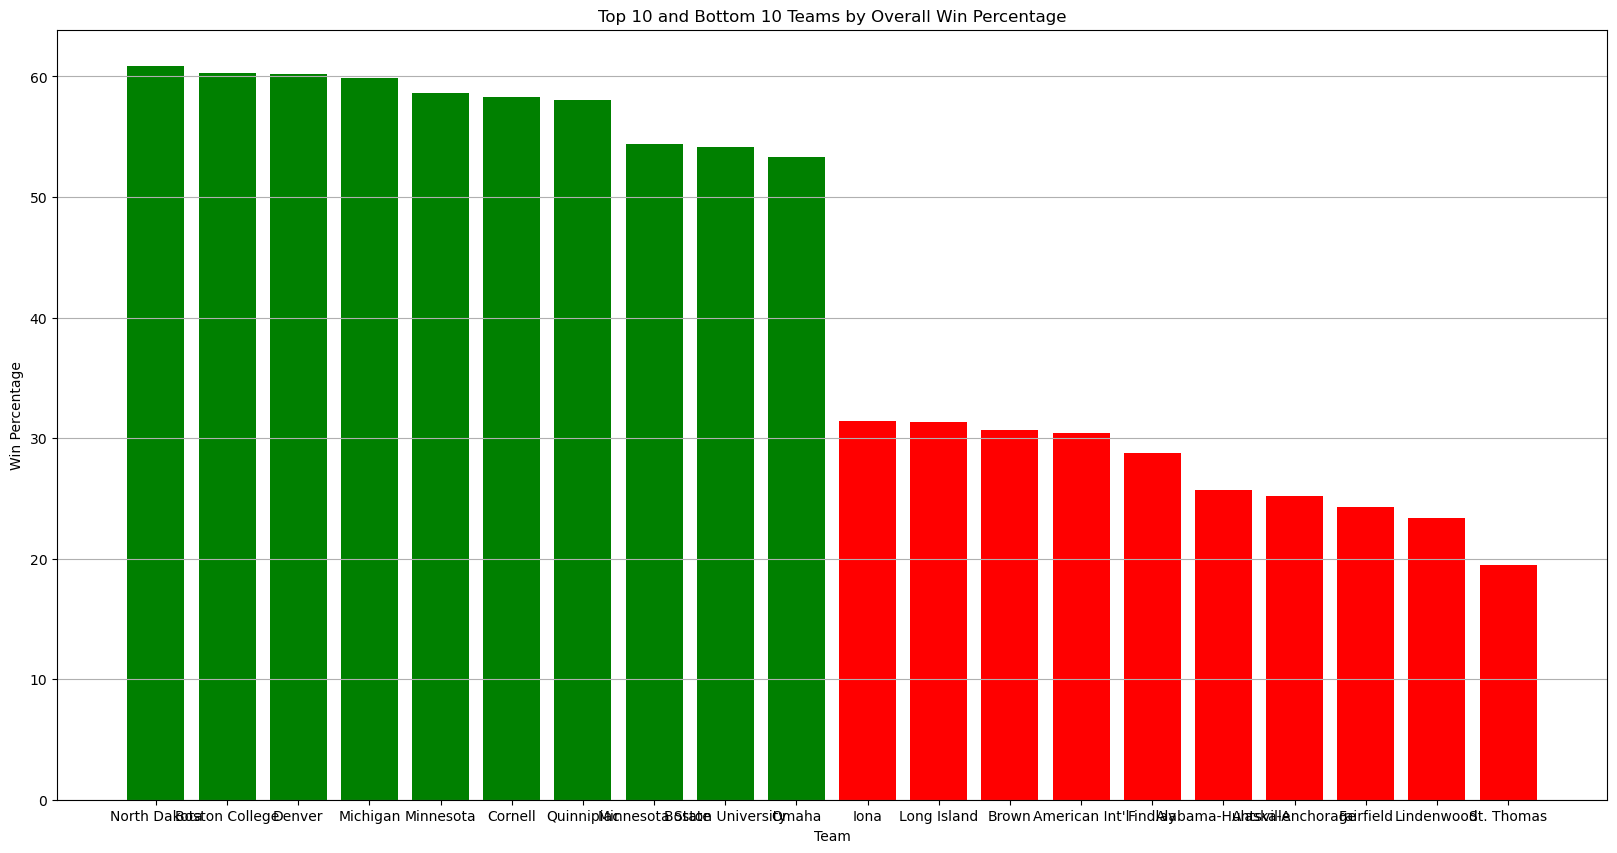

In [28]:
## drop teams from data if they have no wins at all
final_df_sorted = final_df_sorted[final_df_sorted['Overall_Wins'] > 0]

## Plot the tops and bottom teams in overall win percentage and label the teams with their names and win lose records
# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the top 10 teams
plt.bar(final_df_sorted['Team'].head(10), final_df_sorted['Overall_Win_Percent'].head(10), color='green')

# Plot the bottom 10 teams
plt.bar(final_df_sorted['Team'].tail(10), final_df_sorted['Overall_Win_Percent'].tail(10), color='red')

# Add labels and title
plt.ylabel('Win Percentage')
plt.xlabel('Team')
plt.title('Top 10 and Bottom 10 Teams by Overall Win Percentage')

# Add grid lines
plt.grid(axis='y')

# show the plot
plt.show()

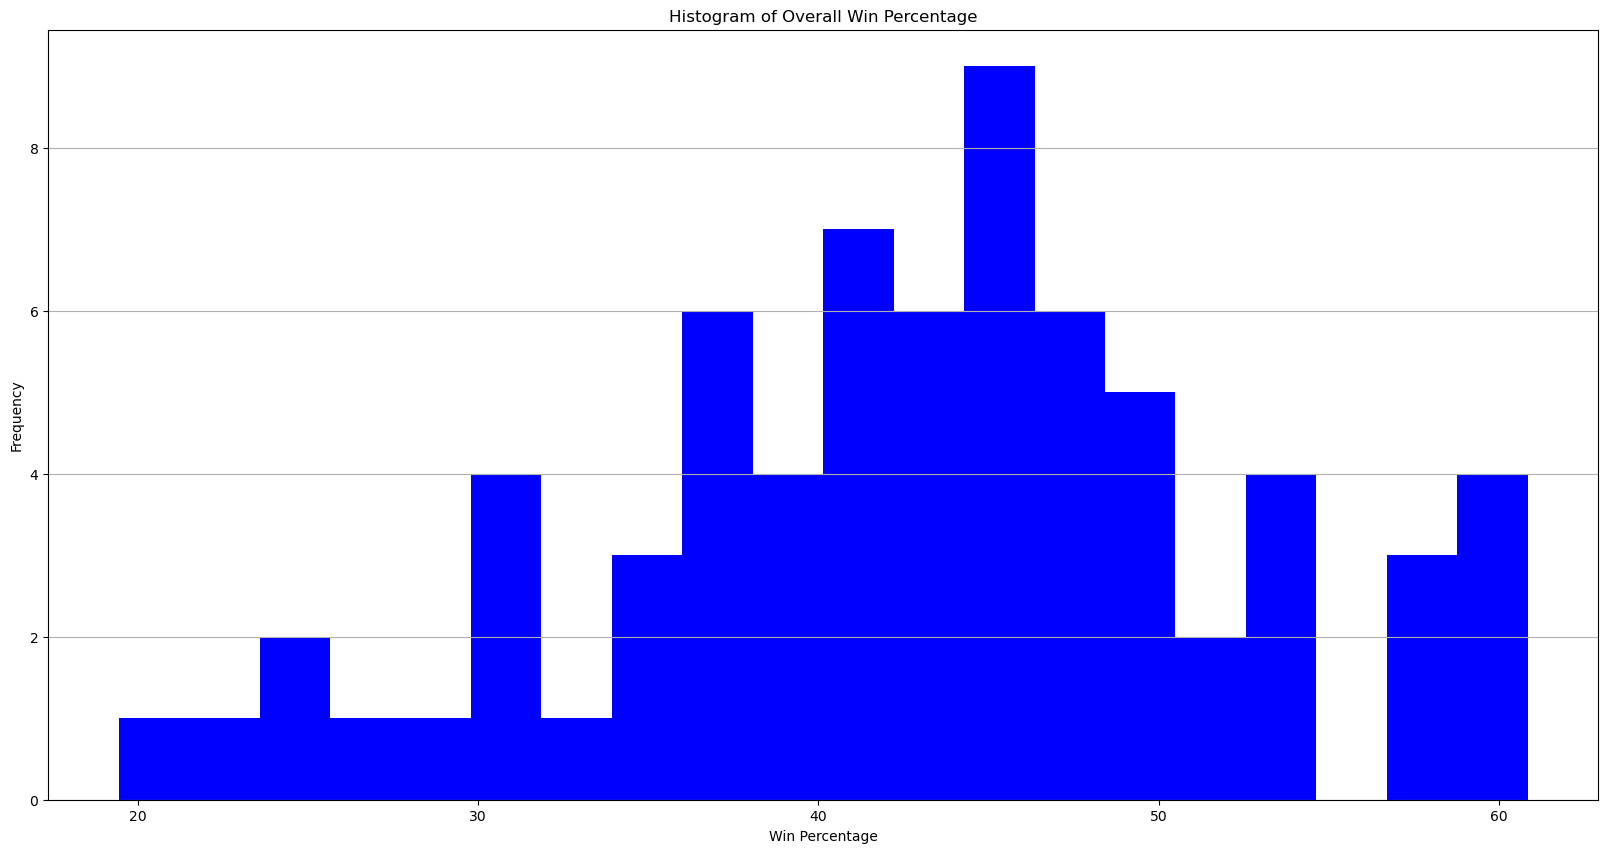

In [29]:
## Create a histogram of the overall win percentage
# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the histogram
plt.hist(final_df_sorted['Overall_Win_Percent'], bins=20, color='blue')

# Add labels and title
plt.ylabel('Frequency')
plt.xlabel('Win Percentage')
plt.title('Histogram of Overall Win Percentage')

# Add grid lines
plt.grid(axis='y')

# show the plot
plt.show()

In [30]:
##### CODE TO MAKE AND PLOT THE A ROLLING $ YEAR AVERAGE OF THE WIN PERCENTAGE
# Convert the 'Date' column to datetime format and extract the year
df_orig['Year'] = pd.to_datetime(df_orig['Date']).dt.year

# Filter out exhibition games
filtered_df = df_orig[df_orig['Conference'] != 'Exhibition']

# Initialize a dictionary to hold annual win counts for each team
annual_wins = defaultdict(lambda: defaultdict(int))

# Initialize a dictionary to hold annual game counts for each team
annual_games = defaultdict(lambda: defaultdict(int))

# Iterate through each row to populate the counts
for idx, row in filtered_df.iterrows():
    home_team, home_score, away_team, away_score, year = row['Home_Team'], row['Home_Score'], row['Away_Team'], row['Away_Score'], row['Year']
    
    # Update annual game counts
    annual_games[home_team][year] += 1
    annual_games[away_team][year] += 1

    # Update annual win counts
    if home_score > away_score:
        annual_wins[home_team][year] += 1
    elif home_score < away_score:
        annual_wins[away_team][year] += 1

# Calculate annual win percentages and create a DataFrame
team_years = []
win_percentages = []

for team, years in annual_games.items():
    for year, total_games in years.items():
        win_count = annual_wins[team].get(year, 0)
        win_percent = (win_count / total_games) * 100
        team_years.append((team, year))
        win_percentages.append(win_percent)

# Create a DataFrame for the annual win percentages
annual_win_df = pd.DataFrame(team_years, columns=['Team', 'Year'])
annual_win_df['Win_Percentage'] = win_percentages

# Sort the DataFrame by Team and Year
annual_win_df.sort_values(['Team', 'Year'], inplace=True)

# Display the first few rows to verify the calculations
annual_win_df.head()


,Team,Year,Win_Percentage
1361,Adrian,2020,0.000000
0,Air Force,2002,44.444444
1,Air Force,2003,24.324324
2,Air Force,2004,45.714286
3,Air Force,2005,26.470588


In [31]:
## Calculate and add the rolling 4 year average to the DataFrame

# Calculate the 4-year rolling average of win percentages for each team
annual_win_df['4Yr_Rolling_Avg'] = annual_win_df.groupby('Team')['Win_Percentage'].rolling(window=4).mean().reset_index(level=0, drop=True)

# Display the first few rows to verify the calculations
# annual_win_df.head(10)


,Team,Year,Win_Percentage,4Yr_Rolling_Avg
1361,Adrian,2020,0.000000,NaN
0,Air Force,2002,44.444444,NaN
1,Air Force,2003,24.324324,NaN
2,Air Force,2004,45.714286,NaN
3,Air Force,2005,26.470588,35.238411
4,Air Force,2006,42.105263,34.653615
5,Air Force,2007,50.000000,41.072534
6,Air Force,2008,66.666667,46.310630
7,Air Force,2009,53.658537,53.107617
8,Air Force,2010,44.444444,53.692412


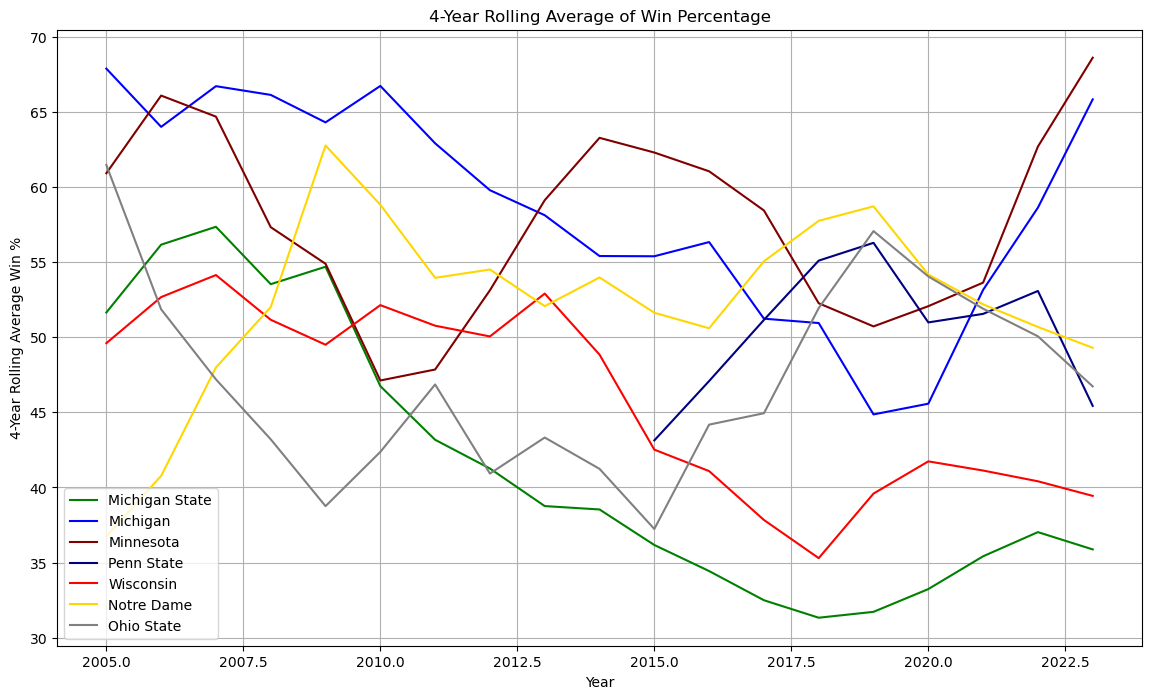

In [32]:
## Create a plot of the rolling average for big ten teams

import matplotlib.pyplot as plt

# Define team colors for the plot
team_colors = {
    'Michigan State': 'green',
    'Michigan': 'blue',
    'Minnesota': 'maroon',
    'Penn State': 'navy',
    'Wisconsin': 'red',
    'Notre Dame': 'gold',
    'Ohio State': 'gray'
}

# Filter the DataFrame to only include the teams of interest
teams_of_interest = ['Michigan State', 'Michigan', 'Minnesota', 'Penn State', 'Wisconsin', 'Notre Dame', 'Ohio State']
filtered_annual_win_df = annual_win_df[annual_win_df['Team'].isin(teams_of_interest)]

# Plot the 4-year rolling averages
plt.figure(figsize=(14, 8))

for team, color in team_colors.items():
    team_data = filtered_annual_win_df[filtered_annual_win_df['Team'] == team]
    plt.plot(team_data['Year'], team_data['4Yr_Rolling_Avg'], label=team, color=color)

plt.title('4-Year Rolling Average of Win Percentage')
plt.xlabel('Year')
plt.ylabel('4-Year Rolling Average Win %')
plt.legend()
plt.grid(True)
plt.show()
